In [1]:
import cv2
from PIL import Image
import torch
import numpy as np
from argparse import Namespace
from torch import nn
import torch.nn.functional as F
import sys
sys.path.append('RAFT/core')
from raft import RAFT


In [2]:
def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()

    if x.is_cuda:
        grid = grid.cuda()
        device = 'cuda'
    else:
        device = 'cpu'
    vgrid = grid + flo
    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    output = F.grid_sample(x, vgrid)
    mask = torch.ones(x.size()).to(device)
    mask = F.grid_sample(mask, vgrid)

    mask[mask < 0.999] = 0
    mask[mask > 0] = 1
    
    return output, mask

In [3]:
args = Namespace(small=False, mixed_precision=True, alternate_corr=False)
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load('RAFT/models/raft-sintel.pth'))
model = model.module
model.to("cuda")
_ = model.eval()

In [ ]:
/home/chuongh/vm2m/data/VIPSeg/out/pha_vid_0911_from-seg/5_Yb4AMwr0vNE/00007406/01.png
/home/chuongh/vm2m/data/VIPSeg/out/pha_vid_0911_from-seg/5_Yb4AMwr0vNE/00007409/01.png

In [5]:
DEVICE = "cuda"
def load_image(imfile, is_gray=False):
    img = Image.open(imfile)
    if is_gray:
        img = img.convert('L')
    ratio = 512.0 / max(img.size)
    if ratio < 1:
        img = img.resize((int(img.size[0] * ratio), int(img.size[1] * ratio)), Image.BILINEAR)
    img = np.array(img).astype(np.uint8)
    if len(img.shape) == 2:
        img = img[:, :, None]
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)

# source_path = "/mnt/localssd/VIPSeg/out/fgr/2_bdIa52B2QGI/00002207.jpg"
# source_pha_path = "/mnt/localssd/VIPSeg/out/pha_image_from-seg/2_bdIa52B2QGI/00002207/00.png"
# target_path = "/mnt/localssd/VIPSeg/out/fgr/2_bdIa52B2QGI/00002210.jpg"
# target_pha_path = "/mnt/localssd/VIPSeg/out/pha_image_from-seg/2_bdIa52B2QGI/00002210/00.png"

source_path = "/mnt/localssd/VIPSeg/out/fgr/5_Yb4AMwr0vNE/00007406.jpg"
source_pha_path = "/home/chuongh/vm2m/data/VIPSeg/out/pha_vid_0911_from-seg/5_Yb4AMwr0vNE/00007406/01.png"
target_path = "/mnt/localssd/VIPSeg/out/fgr/5_Yb4AMwr0vNE/00007409.jpg"
target_pha_path = "/home/chuongh/vm2m/data/VIPSeg/out/pha_vid_0911_from-seg/5_Yb4AMwr0vNE/00007409/01.png"

source_img = load_image(source_path)
target_img = load_image(target_path)

In [6]:
_, flow_right = model(source_img, target_img, iters=20, test_mode=True)
_, flow_left = model(target_img, source_img, iters=20, test_mode=True)

/opt/conda/envs/mask2matte/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [32]:
# flow_combine = flow_right 
# Warp left -> right -> left: If the same value as left --> consistent pixels --> constraint

target_pha = load_image(target_pha_path, is_gray=True)
source_pha = load_image(source_pha_path, is_gray=True)

warped_source, _ = warp(target_pha / 255.0, flow_right)
warped_target, _ = warp(warped_source, flow_left)

warped_target_2, mask_target = warp(source_pha / 255.0, flow_left)

# Correct it
correct_mask = ((target_pha - warped_target * 255) < 5) & (mask_target == 1)
new_target_mask = correct_mask.float() * (warped_target_2 * 255) + (1 - correct_mask.float()) * target_pha

/opt/conda/envs/mask2matte/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


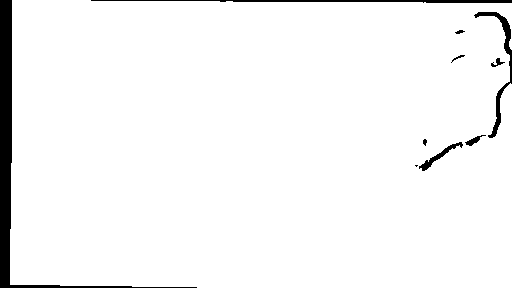

In [33]:
Image.fromarray((correct_mask[0, 0].cpu().numpy() * 255).astype(np.uint8))

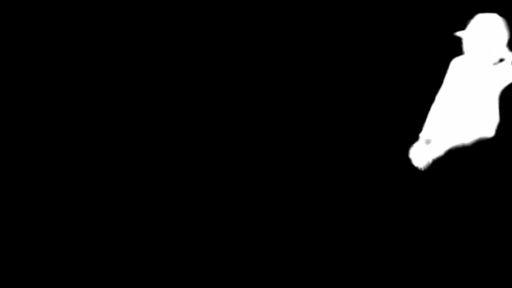

In [34]:
Image.fromarray((target_pha[0, 0].detach().cpu().numpy()).astype(np.uint8))

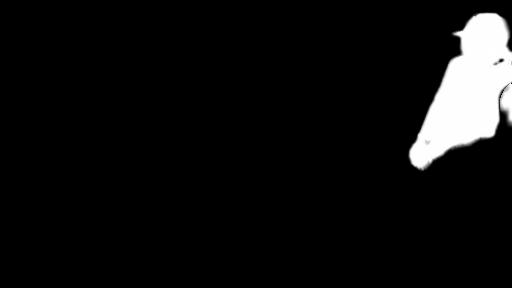

In [35]:
Image.fromarray((new_target_mask[0, 0].detach().cpu().numpy()).astype(np.uint8))

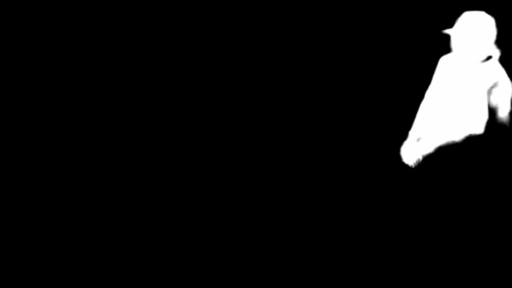

In [36]:
Image.fromarray((source_pha[0, 0].detach().cpu().numpy()).astype(np.uint8))

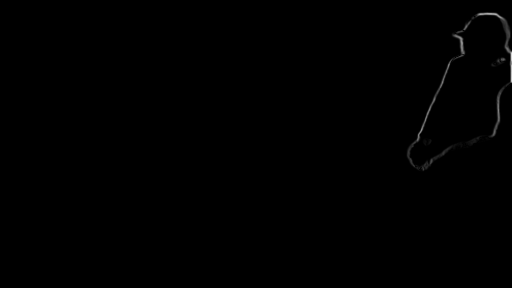

In [9]:
# The mask of erros of points should be ignored checking during warping
Image.fromarray(np.abs(target_pha[0, 0].cpu().numpy() - warped_target[0,0].detach().cpu().numpy() * 255).astype(np.uint8))

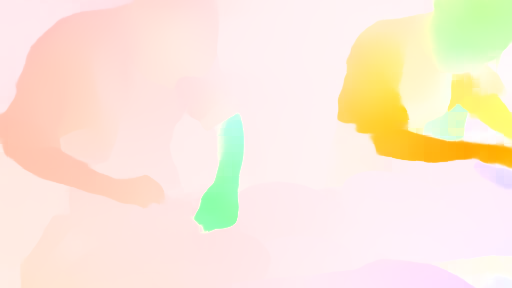

In [9]:
flow_img = flow_to_image(flow_left[0].permute(1,2,0).detach().cpu().numpy(), convert_to_bgr=True)
Image.fromarray(flow_img)

In [6]:
target_pha = load_image(target_pha_path, is_gray=True)
source_pha = load_image(source_pha_path, is_gray=True)

In [7]:
x = target_pha
flo = flow_right
B, C, H, W = x.size()
# mesh grid
xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
grid = torch.cat((xx, yy), 1).float()

if x.is_cuda:
    grid = grid.cuda()
    device = 'cuda'
else:
    device = 'cpu'
vgrid = grid + flo
# scale grid to [-1,1]
vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

vgrid = vgrid.permute(0, 2, 3, 1)
# output = F.grid_sample(x, vgrid)
# mask = torch.ones(x.size()).to(device)
# mask = F.grid_sample(mask, vgrid)

In [29]:
# flo0, 220: 230, 222:242, 0].max()
flo[0,0, 220: 230, 222:242]

tensor([[14.4639,  5.9903,  3.3616,  3.2805,  3.2546,  3.2402,  3.2351,  3.2335,
          3.2317,  3.2286,  3.1899,  3.1773,  3.1631,  3.1409,  3.1158,  3.0771,
          3.0329,  2.9987,  2.9455,  2.9324],
        [14.1915,  5.0254,  3.3155,  3.2713,  3.2588,  3.2451,  3.2348,  3.2307,
          3.2284,  3.2257,  3.1937,  3.1799,  3.1636,  3.1441,  3.1245,  3.0906,
          3.0470,  3.0064,  2.9366,  2.9222],
        [13.6887,  4.4544,  3.2836,  3.2693,  3.2665,  3.2520,  3.2353,  3.2283,
          3.2256,  3.2232,  3.1931,  3.1791,  3.1631,  3.1455,  3.1290,  3.1024,
          3.0638,  3.0194,  2.9372,  2.9173],
        [12.7179,  4.1625,  3.2676,  3.2591,  3.2713,  3.2592,  3.2414,  3.2300,
          3.2275,  3.2213,  3.1889,  3.1747,  3.1615,  3.1467,  3.1323,  3.1148,
          3.0833,  3.0377,  2.9527,  2.9288],
        [13.6123,  4.3872,  3.3708,  3.3402,  3.3405,  3.3369,  3.3230,  3.3006,
          3.2836,  3.2741,  3.2037,  3.1830,  3.1629,  3.1436,  3.1193,  3.0953,
      

In [28]:
flow_right.shape

torch.Size([1, 2, 288, 512])

In [29]:
target_pha.shape

torch.Size([1, 1, 288, 512])

In [57]:
warped_pha_right, mask = warp(target_pha / 255.0, flow_right)
warped_pha_left, mask = warp(source_pha / 255.0, flow_left)

/opt/conda/envs/mask2matte/lib/python3.8/site-packages/torch/nn/functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [40]:
target_pha.shape

torch.Size([1, 1, 288, 512])

In [19]:
Image.fromarray(target_pha[0, 0, 220: 230, 222:242].detach().cpu().numpy() * 255).convert('L')

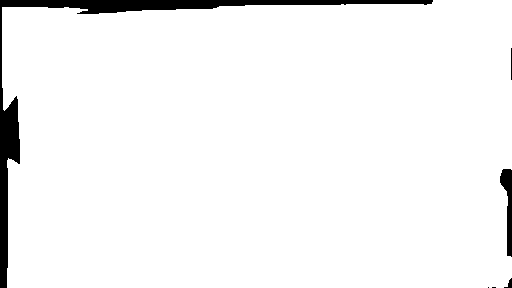

In [71]:
Image.fromarray(mask[0, 0].detach().cpu().numpy() * 255).convert('L')

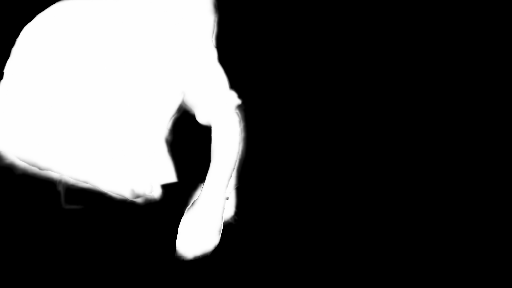

In [59]:
Image.fromarray((warped_pha_right[0, 0].detach().cpu().numpy() * 255).astype(np.uint8))

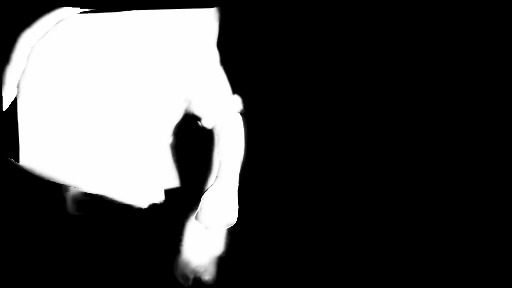

In [60]:
Image.fromarray((warped_pha_left[0, 0].detach().cpu().numpy() * 255).astype(np.uint8))

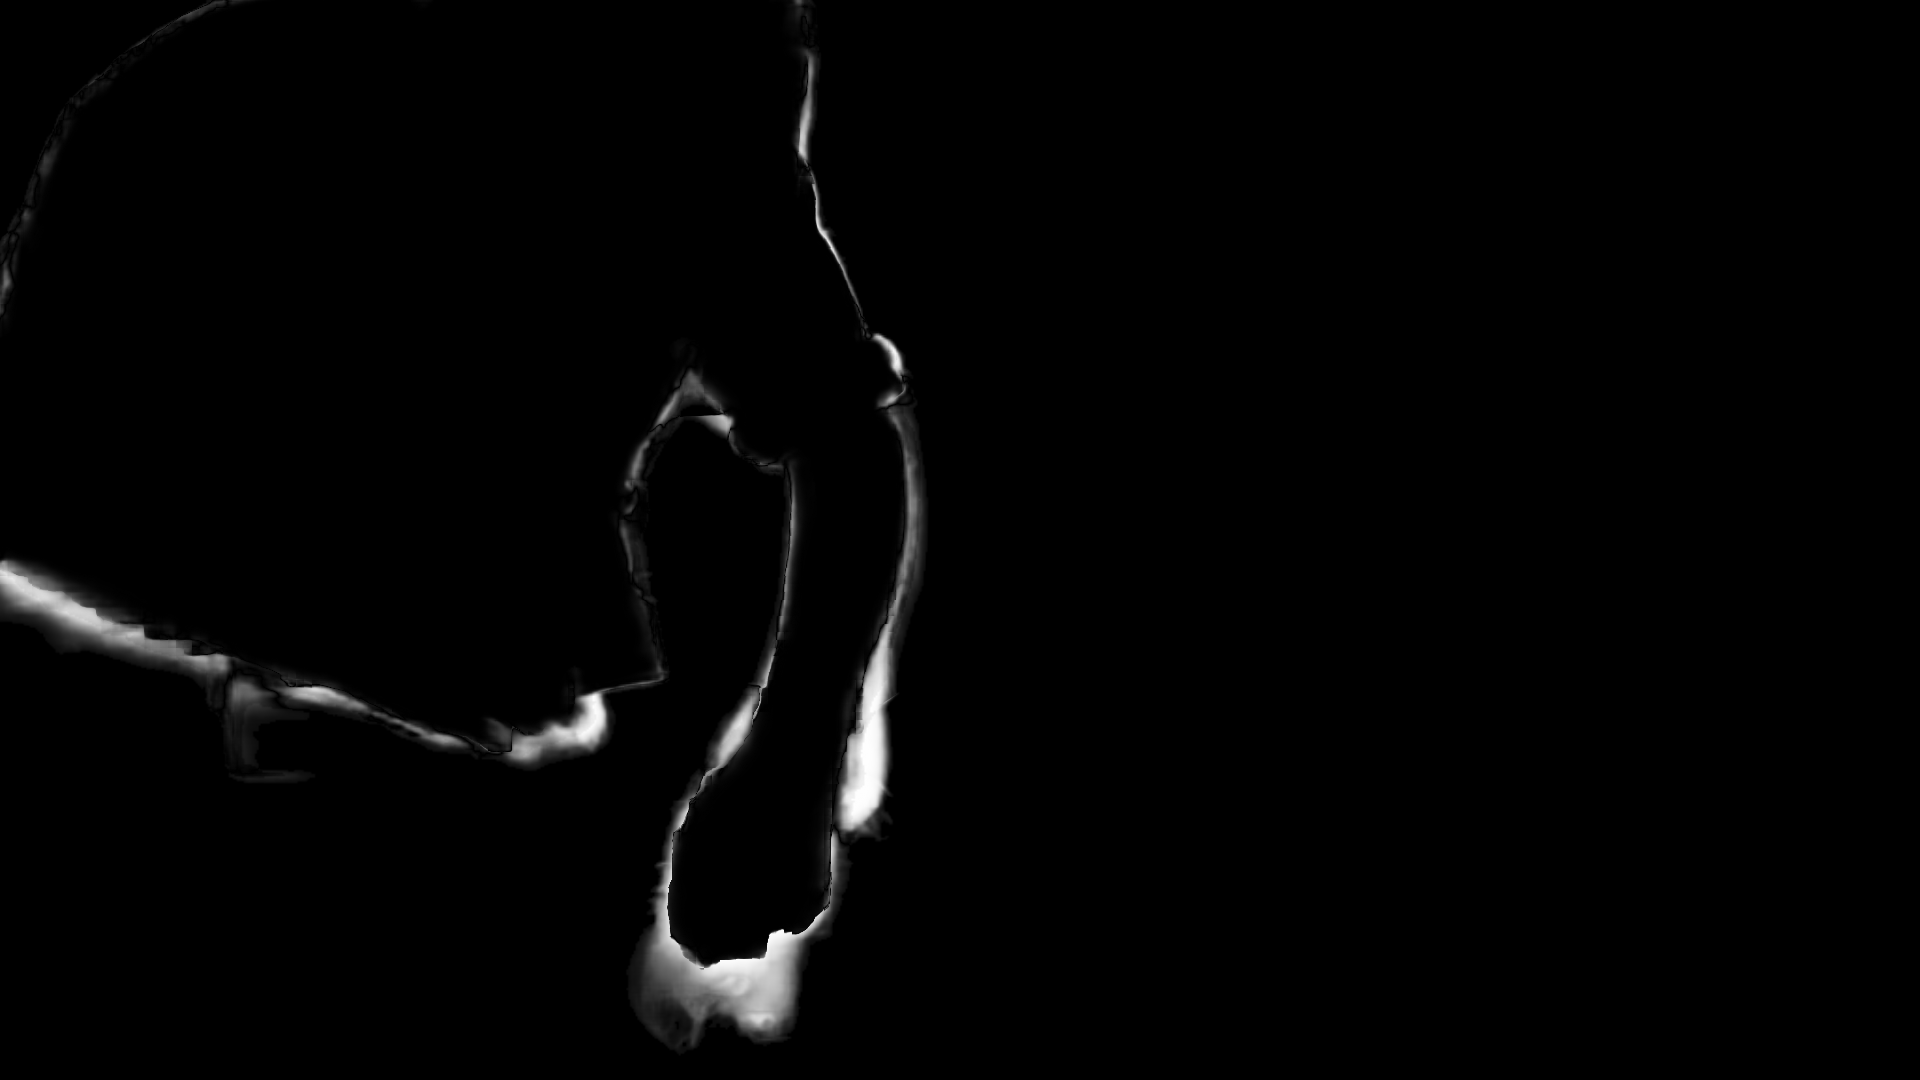

In [19]:
source_pha = np.array(Image.open(source_pha_path).convert('L')) / 255.
diff = np.abs(source_pha - warped_pha[0,0].detach().cpu().numpy())
Image.fromarray((diff * 255).astype(np.uint8))

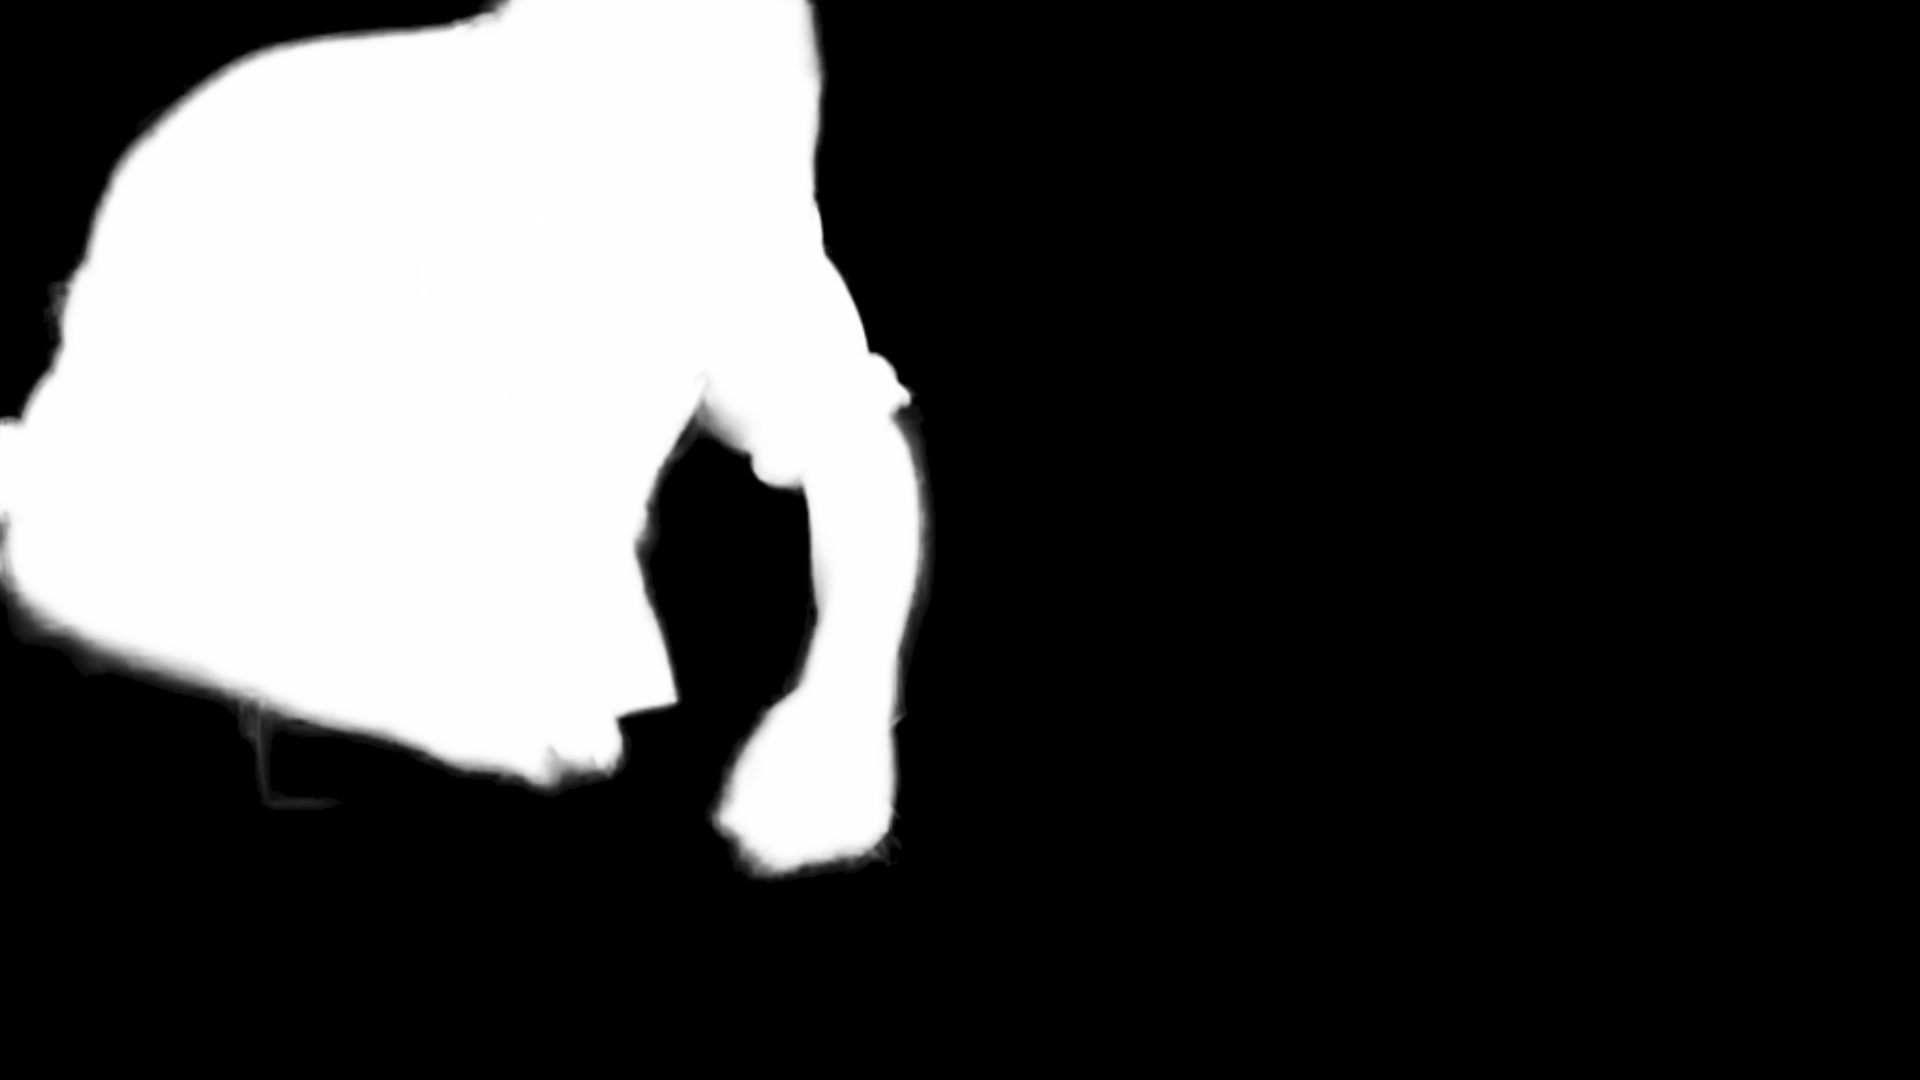

In [34]:
Image.open(target_pha_path)

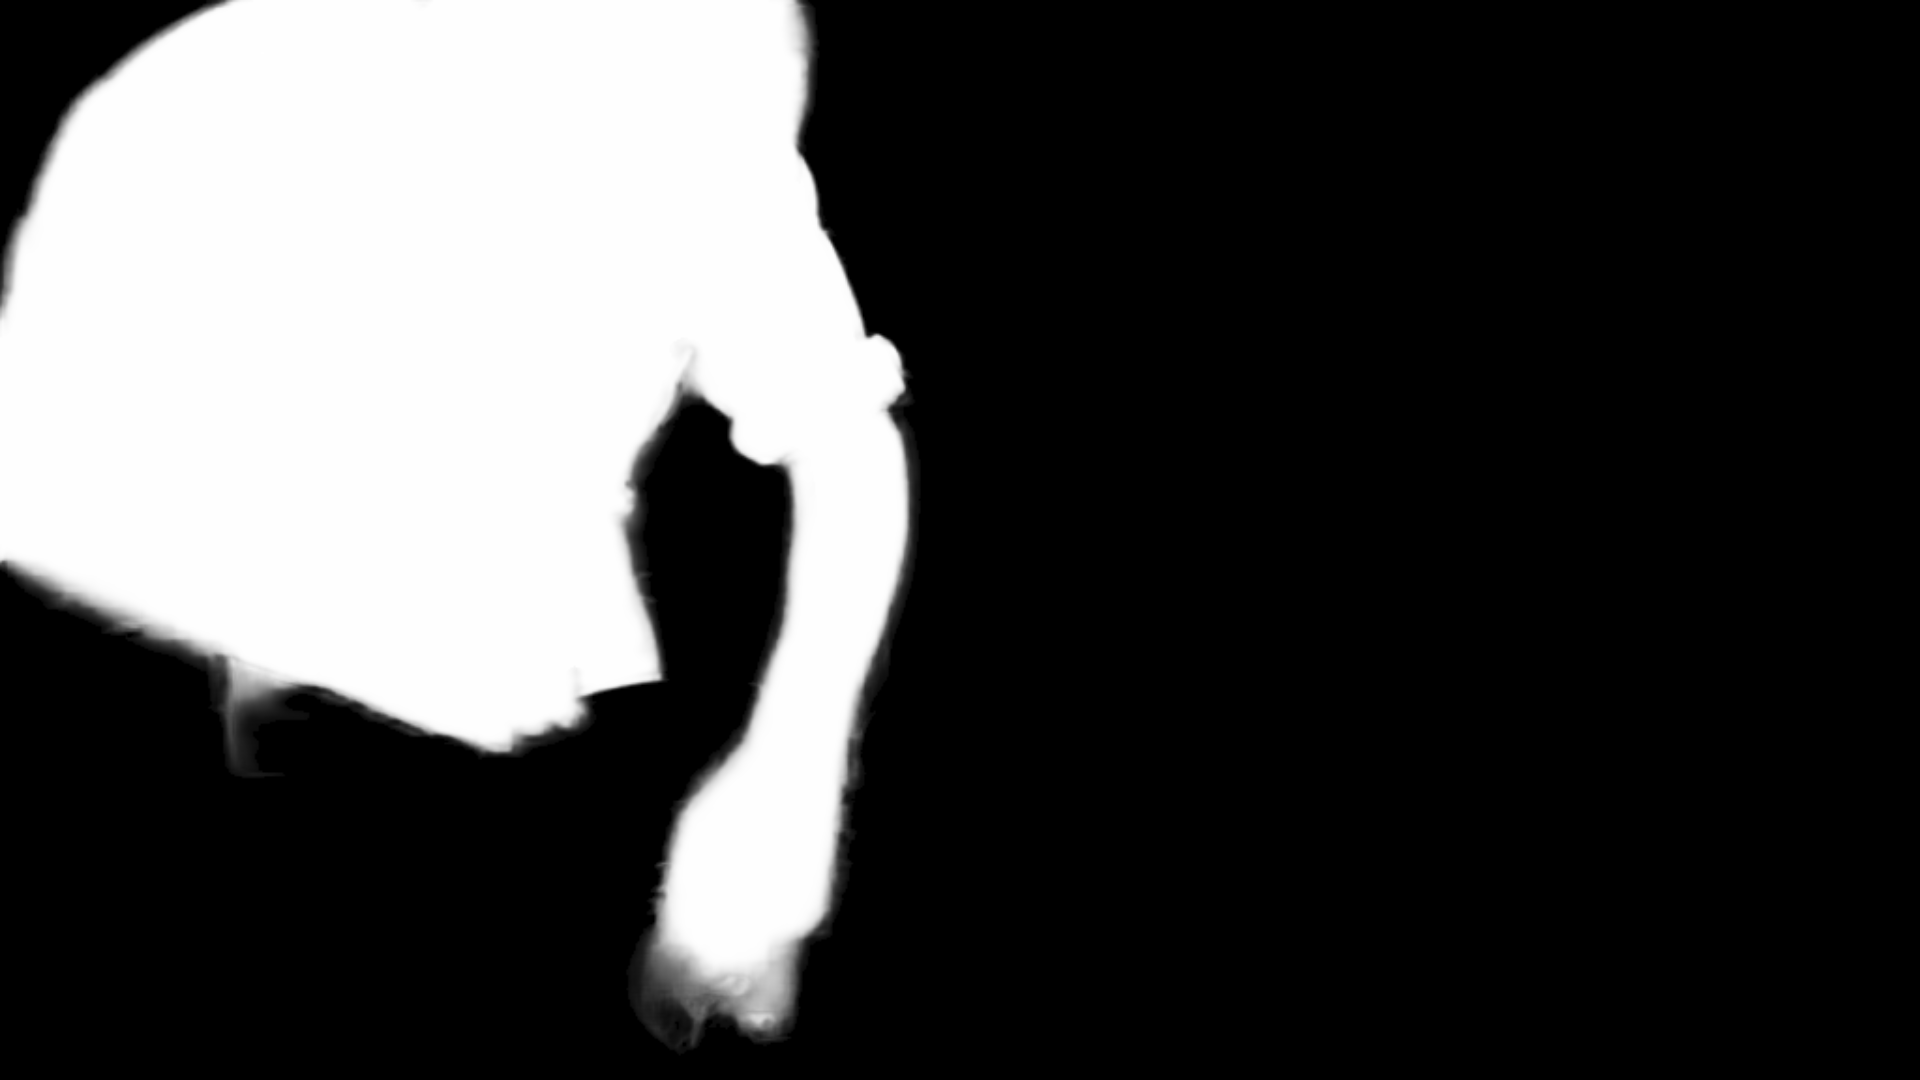

In [41]:
Image.open(source_pha_path)

In [6]:
import numpy as np

def make_colorwheel():
    """
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf

    Code follows the original C++ source code of Daniel Scharstein.
    Code follows the the Matlab source code of Deqing Sun.

    Returns:
        np.ndarray: Color wheel
    """

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_uv_to_colors(u, v, convert_to_bgr=False):
    """
    Applies the flow color wheel to (possibly clipped) flow components u and v.

    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun

    Args:
        u (np.ndarray): Input horizontal flow of shape [H,W]
        v (np.ndarray): Input vertical flow of shape [H,W]
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.

    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)
    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]
    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi
    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0
    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1
        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range
        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:,:,ch_idx] = np.floor(255 * col)
    return flow_image
    
def flow_to_image(flow_uv, clip_flow=None, convert_to_bgr=False):
    """
    Expects a two dimensional flow image of shape.

    Args:
        flow_uv (np.ndarray): Flow UV image of shape [H,W,2]
        clip_flow (float, optional): Clip maximum of flow values. Defaults to None.
        convert_to_bgr (bool, optional): Convert output image to BGR. Defaults to False.

    Returns:
        np.ndarray: Flow visualization image of shape [H,W,3]
    """
    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'
    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)
    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]
    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)
    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)
    return flow_uv_to_colors(u, v, convert_to_bgr)

In [38]:
flow_img = flow_to_image(flow_right[0].permute(1,2,0).detach().cpu().numpy(), convert_to_bgr=True)

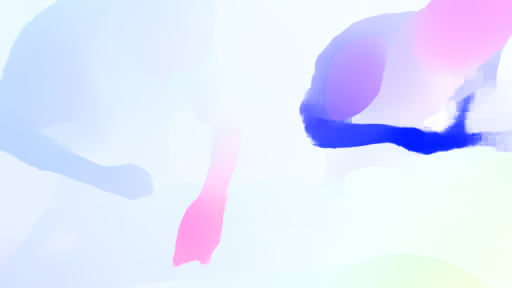

In [39]:
Image.fromarray(flow_img)

In [64]:
warped_mask = cv2.remap(target_pha[0,0].cpu().numpy().astype(np.float32), flow_right.permute(0,2,3,1).detach().cpu().numpy()[0], None, interpolation=cv2.INTER_LINEAR)

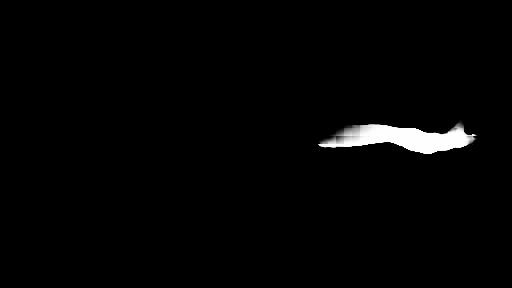

In [67]:
Image.fromarray(warped_mask.astype('uint8'))

In [72]:
flow_right.shape

torch.Size([1, 2, 288, 512])

In [73]:
target_pha.shape

torch.Size([1, 1, 288, 512])

In [83]:
binary_mask = target_pha[0,0].cpu().numpy()

# Create a grid of coordinates for remapping
h, w = binary_mask.shape
x, y = np.meshgrid(np.arange(w), np.arange(h))
x = x + flow_right[0, 0].detach().cpu().numpy()  # Add horizontal flow
y = y + flow_right[0, 1].detach().cpu().numpy()  # Add vertical flow

flow_map = np.stack((x, y), axis=-1)

warped_mask = cv2.remap(binary_mask, flow_map.astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT)

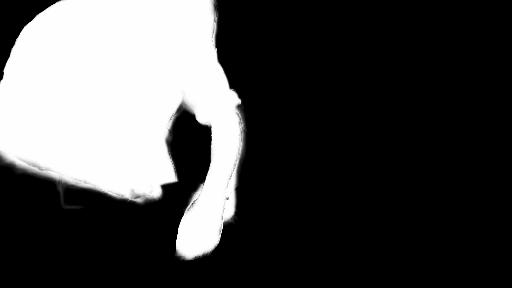

In [84]:
Image.fromarray(warped_mask.astype('uint8'))

In [41]:
binary_mask = target_pha[0,0].cpu().numpy()
warped_mask = np.zeros_like(binary_mask)

for y in range(binary_mask.shape[0]):
    for x in range(binary_mask.shape[1]):
        flow_x, flow_y = flow_right[0,:, y, x].detach().cpu().numpy()
        new_x, new_y = int(round(x + flow_x)), int(round(y + flow_y))

        # Check if the new coordinates are within the mask boundaries
        if 0 <= new_x < binary_mask.shape[1] and 0 <= new_y < binary_mask.shape[0]:
            warped_mask[y, x] = binary_mask[new_y, new_x]


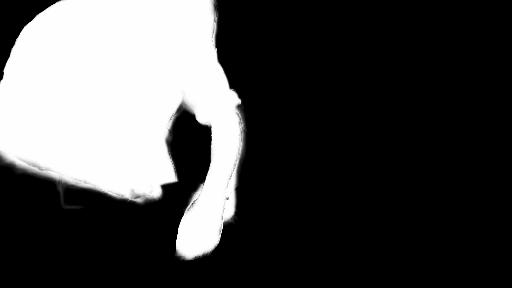

: 

In [42]:
Image.fromarray(warped_mask.astype('uint8'))

In [40]:
binary_mask.shape

(288, 512)